In [35]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


#1. Git clone darknet

In [1]:
!git clone https://github.com/AlexeyAB/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 15050, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 15050 (delta 16), reused 34 (delta 14), pack-reused 15002
Receiving objects: 100% (15050/15050), 13.48 MiB | 15.69 MiB/s, done.
Resolving deltas: 100% (10215/10215), done.


In [5]:
!ls darknet

3rdparty		darknet_video.py       net_cam_v4.sh
build			data		       README.md
build.ps1		image_yolov3.sh        results
cfg			image_yolov4.sh        scripts
cmake			include		       src
CMakeLists.txt		json_mjpeg_streams.sh  vcpkg.json
DarknetConfig.cmake.in	LICENSE		       video_yolov3.sh
darknet_images.py	Makefile	       video_yolov4.sh
darknet.py		net_cam_v3.sh


In [6]:
%cd darknet

/content/darknet


In [7]:
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile

In [ ]:
!make

In [9]:
!wget https://pjreddie.com/media/files/yolov3.weights

--2021-05-22 05:01:43--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  45.1MB/s    in 5.6s    

2021-05-22 05:01:49 (42.3 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]



In [10]:
!ls

3rdparty	DarknetConfig.cmake.in	json_mjpeg_streams.sh  scripts
backup		darknet_images.py	LICENSE		       src
build		darknet.py		Makefile	       vcpkg.json
build.ps1	darknet_video.py	net_cam_v3.sh	       video_yolov3.sh
cfg		data			net_cam_v4.sh	       video_yolov4.sh
cmake		image_yolov3.sh		obj		       yolov3.weights
CMakeLists.txt	image_yolov4.sh		README.md
darknet		include			results


In [27]:
!ls data

9k.tree     eagle.jpg	 imagenet.labels.list	   person.jpg
coco9k.map  giraffe.jpg  imagenet.shortnames.list  scream.jpg
coco.names  goal.txt	 labels			   voc.names
dog.jpg     horses.jpg	 openimages.names


#2. Prepare YOLO

In [47]:
import cv2
from google.colab.patches import cv2_imshow
import IPython
import numpy as np
import math
import time

In [46]:
weight_file = 'yolov3.weights'
cfg_file = 'cfg/yolov3.cfg'
name_file = 'data/coco.names'
file_name = '/gdrive/MyDrive/darknet/cabc30fc-e7726578.mp4'

net = cv2.dnn.readNet(weight_file,cfg_file)

In [17]:
classes = []
with open(name_file, 'r') as f:
    classes = [line.strip('\n') for line in f.readlines()]
    print(classes)

['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [30]:
len(classes)

80

In [29]:
np.array((0,255,255))

array([  0, 255, 255])

In [55]:
layer_names = net.getLayerNames()
output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]
colors = [int(255/len(classes)*i) for i in range(len(classes))]

#3. Use YOLO

In [56]:
def detection(frame):
    IPython.display.clear_output(wait=True)
    height, width, channel = frame.shape
    blob = cv2.dnn.blobFromImage(frame, 1/255, (416, 416), (0, 0, 0))
    net.setInput(blob)
    outs = net.forward(output_layers)
    class_ids = []
    confidences = []
    boxes = []
    min_confidence = 0.5

    for detections in outs:
        for detection in detections:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > min_confidence:
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)
                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)
    nmsboxes = cv2.dnn.NMSBoxes(boxes, confidences, min_confidence, 0.4)
    for i in range(len(boxes)):
        if i in nmsboxes:
            x, y, w, h = boxes[i]
            label = str(classes[class_ids[i]])
            color = colors[i]
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0,255,color), 2)
            cv2.putText(frame, label, (x, y + 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)  
            
    cv2_imshow(frame)

#4. Save result video

In [57]:
def writeVideo(frame):
    global writer
    height, width = frame.shape[:2]
    if writer is None and result_video is not None:
        fourcc = cv2.VideoWriter_fourcc(*'MJPG')
        writer = cv2.VideoWriter(result_video, fourcc, 24, (width, height), True)
    if writer is not None:
        writer.write(frame)

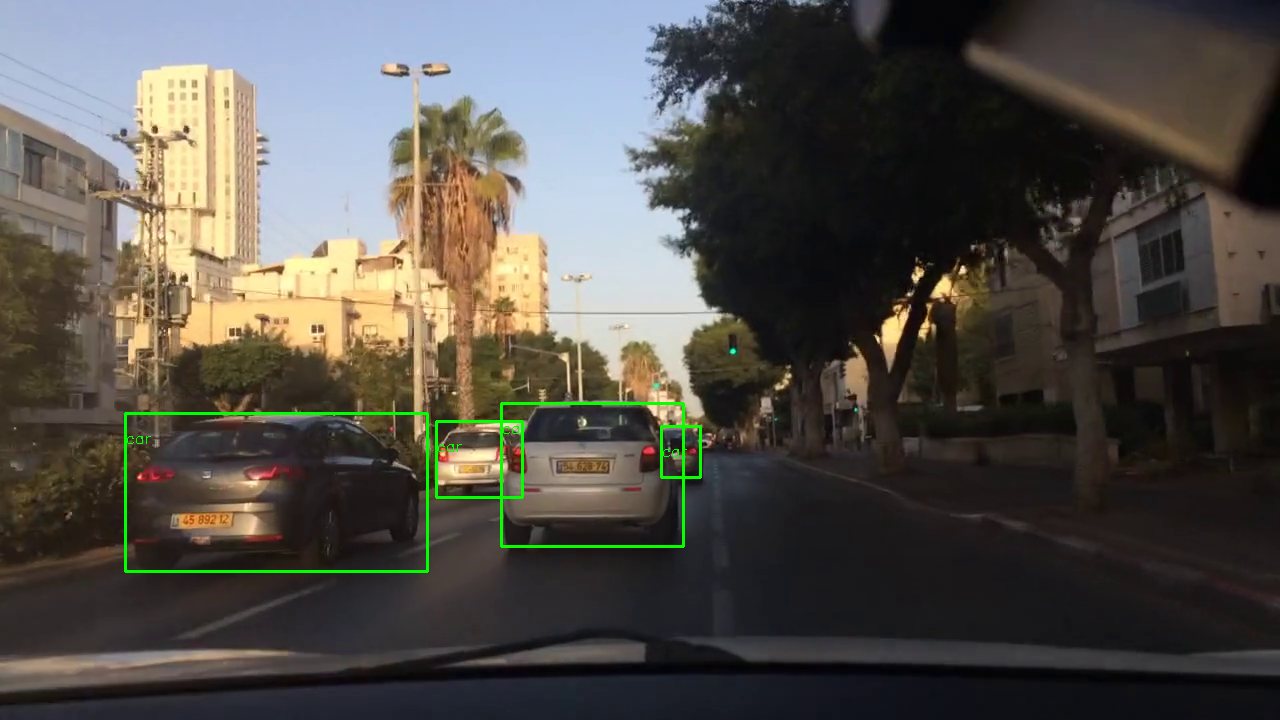

In [ ]:
cap = cv2.VideoCapture(file_name)
result_video = 'result.avi'
writer = None
while True:
    ret, frame = cap.read()
    if not ret:
        print('No more frame remains !')
        break
    detection(frame)
    writeVideo(frame)